<a href="https://colab.research.google.com/github/mc2259/Sentiment_Analaysis_of_Tweets/blob/master/Sentiment_Analysis_Of_Tweets_Using_Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import pdb
from nltk.corpus import stopwords, twitter_samples
import numpy as np
import pandas as pd
import nltk
import string
from nltk.tokenize import TweetTokenizer
from nltk.corpus import twitter_samples    # sample Twitter dataset from NLTK
import matplotlib.pyplot as plt            # library for visualization
import random 
from os import getcwd
from nltk.stem import PorterStemmer  

In [ ]:
nltk.download('stopwords')
nltk.download('twitter_samples')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.


True

Creating Training and Test Dataset

In [ ]:

positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
test_pos = positive_tweets[4000:]
train_pos = positive_tweets[:4000]
test_neg = negative_tweets[4000:]
train_neg = negative_tweets[:4000]
train_x = train_pos + train_neg
test_x = test_pos + test_neg
train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))
test_y = np.append(np.ones(len(test_pos)), np.zeros(len(test_neg)))

PREPROCESSING USING LEMMATIZATION AND STEMMING

In [ ]:
def process_tweets(tweet):
  tweet2 = re.sub(r'^RT[\s]+', '', tweet)
  tweet2 = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet2)

  tweet2 = re.sub(r'#', '', tweet2)
  tokenizer=TweetTokenizer(preserve_case=False,strip_handles=True,reduce_len=True)
  tweet_token=tokenizer.tokenize(tweet2)

  tweets_clean = []
  stopwords_english = stopwords.words('english') 

  for word in tweet_token: 
    if (word not in stopwords_english and word not in string.punctuation):  # remove punctuation
      tweets_clean.append(word)
  stemmer = PorterStemmer() 
  tweets_stem = [] 
  for word in tweets_clean:
    stem_word=stemmer.stem(word)
    tweets_stem.append(stem_word)


  return tweets_stem

In [ ]:
# print(process_tweets(train_x[400]))
# print(train_x[400])
# print(process_tweets('My beautiful sunflowers on a sunny Friday morning off :) sunflowers favourites happy Friday off…'))

['old', 'pic', ':)']
@ernezpjy its old pic :)
['beauti', 'sunflow', 'sunni', 'friday', 'morn', ':)', 'sunflow', 'favourit', 'happi', 'friday', '…']


In [ ]:
def lookup(freqs,word,label):
  """ A helper function that returns the frequency of a word in the dictionary that contains label"""
  

  tup=tuple((str(word),label))
  if tup in freqs.keys():
    return freqs[tup]
  else:
    return 0


Preprocessing Data

In [ ]:
def count_tweets(tweets, labels):
    '''
    
        @param tweets: a list of tweets
        @param ys: a list corresponding to the sentiment of each tweet (either 0 or 1)
    Output:
        result: a dictionary mapping each pair to its frequency
    '''

    result={}
    for y, tweet in zip(labels, tweets):
        for word in process_tweets(tweet):
            pair = tuple((word,y))
            if pair in result:
                result[pair] += 1
            else:
                result[pair] = 1


    return result

In [ ]:

tweets = ['i am happy', 'i am tricked', 'i am sad', 'i am tired', 'i am tired']
labels = [1, 0, 0, 0, 0]
count_tweets(tweets, labels)

{('happi', 1): 1, ('sad', 0): 1, ('tire', 0): 2, ('trick', 0): 1}

In [ ]:


freqs = count_tweets(train_x, train_y)
print(lookup(freqs,'week',1.0))


72


TRAINING THE NAIVE BAYES CLASSIFIER

In [ ]:

def train_naive_bayes(freqs, train_x, train_y):
    '''
        @param freqs: dictionary from (word, label) to how often the word appears
        @param train_x: a list of tweets
        @param train_y: a list of labels correponding to the tweets (0,1)
    Output:
        logprior: the log prior
        loglikelihood: the log likelihood of you Naive bayes equation
    '''
    loglikelihood = {}
    logprior = 0
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)
    N_pos = N_neg = 0
    for pair in freqs.keys():
        if pair[1] > 0:
            N_pos += freqs[pair]
        else:
            N_neg += freqs[pair]

    D = len(train_y)
    D_pos = sum(np.array(train_y))
    D_neg = D-D_pos


    logprior = np.log(D_pos)-np.log(D_neg)

    for word in vocab:
        freq_pos = lookup(freqs,word,1.0)
        freq_neg = lookup(freqs,word,0.0)
        p_w_pos = (freq_pos+1)/(N_pos+V)
        p_w_neg = (freq_neg+1)/(N_neg+V)
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)
      
    
    return logprior, loglikelihood


In [ ]:

logprior, loglikelihood = train_naive_bayes(freqs, train_x, train_y)
print(logprior)
print(len(loglikelihood))




0.0
9088


In [ ]:

def naive_bayes_predict(tweet, logprior, loglikelihood):
    '''
    Input:
        @param tweet: a string
        @param logprior: a number
        @param loglikelihood: a dictionary of words mapping to numbers
    Output:
        p: the sum of all the loglikliho ods of each word in the tweet (if found in the dictionary) + logprior (a number)

    '''
    word_l = process_tweets(tweet)
    p = 0
    p += logprior

    for word in word_l:
        if word in loglikelihood:
            p += loglikelihood[word]

    return p


In [ ]:

def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Returns the accuracy of the tweets after testing
    """
    accuracy = 0  
    y_hats = []
    for tweet in test_x:
        if naive_bayes_predict(tweet, logprior, loglikelihood) > 0:
            y_hat_i = 1
        else:
            y_hat_i = 0
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = np.average(abs(y_hats-test_y))

    # Accuracy is 1 minus the error
    accuracy = 1-error
    return accuracy


In [ ]:
print(test_naive_bayes(test_x,test_y,logprior,loglikelihood))

0.994


In [ ]:

for tweet in ['I am happy', 'I am bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great']:
    # print( '%s -> %f' % (tweet, naive_bayes_predict(tweet, logprior, loglikelihood)))
    p = naive_bayes_predict(tweet, logprior, loglikelihood)
#     print(f'{tweet} -> {p:.2f} ({p_category})')
    print(f'{tweet} -> {p:.2f}')
my_tweet = 'I smiled.'
my_twee2t = 'I  am excited.'
p = naive_bayes_predict(my_twee2t, logprior, loglikelihood)
print('The expected output :',my_twee2t, p)
my_tweet3 = 'you are bad :('
p2 = naive_bayes_predict(my_tweet3, logprior, loglikelihood)
print('The expected output :',my_tweet3, p2)

I am happy -> 2.15
I am bad -> -1.29
this movie should have been great. -> 2.14
great -> 2.14
great great -> 4.28
great great great -> 6.41
great great great great -> 8.55
The expected output : I  am excited. 1.7634359197769378
The expected output : you are bad :( -8.801290524915208


In [ ]:

def get_ratio(freqs, word):
 
    ''' Returns Ratio of positive to Negative counts for a word'''
    
    pos_neg_ratio = {'positive': 0, 'negative': 0, 'ratio': 0.0}
    pos_neg_ratio['positive'] = lookup(freqs,word,1)
    pos_neg_ratio['negative'] = lookup(freqs,word,0)
    pos_neg_ratio['ratio'] = ( pos_neg_ratio['positive']+1)/(pos_neg_ratio['negative']+1)

    return pos_neg_ratio


In [ ]:
p=get_ratio(freqs, 'happi')
part1=p['negative']
part2=p['positive']
print(p)

{'positive': 161, 'negative': 18, 'ratio': 8.526315789473685}


Finding the Positive vs Negative frequency of the word Happy

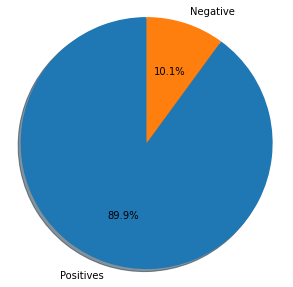

In [ ]:

fig = plt.figure(figsize=(5, 5))
labels = 'Positives', 'Negative'
sizes = [part2, part1] 
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')  
plt.show()

In [ ]:

def get_words_by_threshold(freqs, label, threshold):
    '''
        Returns:
        word_set: dictionary containing the word and information on its positive count, negative count, and ratio of positive to negative counts.
        example of a key value pair:
        {'happi':
            {'positive': 10, 'negative': 20, 'ratio': 0.5}
        }
    '''
    word_list = {}
    for key in freqs.keys():
        word, _ = key
        pos_neg_ratio = lookup(freqs,word,label)
        if label == 1 and pos_neg_ratio>threshold:
            word_list[word]=get_ratio(freqs,word)
        elif label == 0 and pos_neg_ratio<=threshold:
            word_list[word]=get_ratio(freqs,word)


    return word_list


In [ ]:
# Test your function: find negative words at or below a threshold
get_words_by_threshold(freqs, label=0, threshold=0.05)

{'followfriday': {'negative': 0, 'positive': 23, 'ratio': 24.0},
 'engag': {'negative': 0, 'positive': 7, 'ratio': 8.0},
 '02392441234': {'negative': 0, 'positive': 1, 'ratio': 2.0},
 'assist': {'negative': 0, 'positive': 1, 'ratio': 2.0},
 'yeaaah': {'negative': 0, 'positive': 1, 'ratio': 2.0},
 'yipppi': {'negative': 0, 'positive': 1, 'ratio': 2.0},
 'accnt': {'negative': 0, 'positive': 2, 'ratio': 3.0},
 'verifi': {'negative': 0, 'positive': 2, 'ratio': 3.0},
 'rqst': {'negative': 0, 'positive': 1, 'ratio': 2.0},
 'succeed': {'negative': 0, 'positive': 1, 'ratio': 2.0},
 'tick': {'negative': 0, 'positive': 1, 'ratio': 2.0},
 'irresist': {'negative': 0, 'positive': 2, 'ratio': 3.0},
 'flipkartfashionfriday': {'negative': 0, 'positive': 16, 'ratio': 17.0},
 'lwwf': {'negative': 0, 'positive': 1, 'ratio': 2.0},
 'bayan': {'negative': 0, 'positive': 1, 'ratio': 2.0},
 ':D': {'negative': 0, 'positive': 498, 'ratio': 499.0},
 'mischiev': {'negative': 0, 'positive': 1, 'ratio': 2.0},
 'etl

In [ ]:
# Test your function; find positive words at or above a threshold
get_words_by_threshold(freqs, label=1, threshold=10)

{'..': {'negative': 89, 'positive': 100, 'ratio': 1.1222222222222222},
 '...': {'negative': 282, 'positive': 227, 'ratio': 0.8056537102473498},
 '1': {'negative': 19, 'positive': 60, 'ratio': 3.05},
 '10': {'negative': 7, 'positive': 15, 'ratio': 2.0},
 '2': {'negative': 35, 'positive': 41, 'ratio': 1.1666666666666667},
 '2015': {'negative': 11, 'positive': 13, 'ratio': 1.1666666666666667},
 '3': {'negative': 31, 'positive': 26, 'ratio': 0.84375},
 '4': {'negative': 16, 'positive': 21, 'ratio': 1.2941176470588236},
 '5': {'negative': 11, 'positive': 15, 'ratio': 1.3333333333333333},
 '6': {'negative': 10, 'positive': 17, 'ratio': 1.6363636363636365},
 ':)': {'negative': 2, 'positive': 2847, 'ratio': 949.3333333333334},
 ':-)': {'negative': 0, 'positive': 543, 'ratio': 544.0},
 ':D': {'negative': 0, 'positive': 498, 'ratio': 499.0},
 ':p': {'negative': 0, 'positive': 103, 'ratio': 104.0},
 ';)': {'negative': 0, 'positive': 22, 'ratio': 23.0},
 '<3': {'negative': 19, 'positive': 118, 'ra

In [ ]:

print('Truth Predicted Tweet')
for x, y in zip(test_x, test_y):
    y_hat = naive_bayes_predict(x, logprior, loglikelihood)
    if y != (np.sign(y_hat) > 0):
        print('%d\t%0.2f\t%s' % (y, np.sign(y_hat) > 0, ' '.join(
            process_tweets(x)).encode('ascii', 'ignore')))

Truth Predicted Tweet
1	0.00	b''
1	0.00	b'truli later move know queen bee upward bound movingonup'
1	0.00	b'new report talk burn calori cold work harder warm feel better weather :p'
1	0.00	b'harri niall 94 harri born ik stupid wanna chang :D'
1	0.00	b''
1	0.00	b''
1	0.00	b'park get sunlight'
1	0.00	b'uff itna miss karhi thi ap :p'
0	1.00	b'hello info possibl interest jonatha close join beti :( great'
0	1.00	b'u prob fun david'
0	1.00	b'pat jay'
0	1.00	b'whatev stil l young >:-('
